# Introduction to Text Analysis


Version 1.0

Date: Nov 23, 2017

Authors: 

   * Jerónimo Arenas-García (jeronimo.arenas@uc3m.es)
   * Jesús Cid-Sueiro (jcid@tsc.uc3m.es)

In [3]:
# Common imports 

%matplotlib inline
import matplotlib.pyplot as plt
import pylab

import numpy as np
# import pandas as pd
# import os
from os.path import isfile, join
# import scipy.io as sio
# import scipy
import zipfile as zp
# import shutil
# import difflib

import gensim

## 1. Corpus acquisition

In this block we will work with collections of text documents. The objectives will be:

   * Find the most important topics in the collection and assign documents to topics
   * Analyze the structure of the collection by means of graph analysis
   
We will work with a collection of research projects funded by the US National Science Foundation, that you can find under the `./data` directory. These files are publicly available from the NSF website.

(*As a side note, there are many other available text collections to work with. In particular, the NLTK library has many examples, that you can explore using the `nltk.download()` tool*.

    import nltk
    nltk.download()

*for instance, you can take the gutemberg dataset*

    Mycorpus = nltk.corpus.gutenberg
    text_name = Mycorpus.fileids()[0]
    raw = Mycorpus.raw(text_name)
    Words = Mycorpus.words(text_name)

*Also, tools like Gensim or Sci-kit learn include text databases to work with*).


### 1.1. Exploring file structure

NSF project information is provided in XML files. Projects are yearly grouped in `.zip` files, and each project is saved in a different XML file. To explore the structure of such files, we will use the file `160057.xml`. Parsing XML files in python is rather easy using the `ElementTree` module. 

To introduce some common functions to work with XML files we will follow <a href=http://docs.python.org/3.4/library/xml.etree.elementtree.html#module-xml.etree.ElementTree>this tutorial</a>.

#### 1.1.1. File format

To start with, you can have a look at the contents of the example file. We are interested on the following information of each project:

   * Project identifier
   * Project Title
   * Project Abstract
   * Budget
   * Starting Year (we will ignore project duration)
   * Institution (name, zipcode, and state)

In [4]:
xmlfile = '../data/1600057.xml'

with open(xmlfile,'r') as fin:
    print(fin.read())

<?xml version="1.0" encoding="UTF-8"?>
<rootTag>
<Award>
<AwardTitle>Novel States in Spin-Orbit-Coupled and Correlated Materials</AwardTitle>
<AwardEffectiveDate>08/01/2016</AwardEffectiveDate>
<AwardExpirationDate>12/31/2016</AwardExpirationDate>
<AwardAmount>306810</AwardAmount>
<AwardInstrument>
<Value>Continuing grant</Value>
</AwardInstrument>
<Organization>
<Code>03070000</Code>
<Directorate>
<LongName>Direct For Mathematical &amp; Physical Scien</LongName>
</Directorate>
<Division>
<LongName>Division Of Materials Research</LongName>
</Division>
</Organization>
<ProgramOfficer>
<SignBlockName>Tomasz Durakiewicz</SignBlockName>
</ProgramOfficer>
<AbstractNarration>Non-technical Abstract:&lt;br/&gt;Modern condensed matter physics research has produced novel materials with fundamental properties that underpin a remarkable number of cutting-edge technologies. It is now generally accepted that novel materials are necessary for critical advances in technologies and whoever discovers no

#### 1.1.2. Parsing XML

XML is an inherently hierarchical data format, and the most natural way to represent it is with a tree. The `ElementTree` module has two classes for this purpose:

   * `ElementTree` represents the whole XML document as a tree
   * `Element` represents a single node in this tree

We can import XML data by reading an XML file:

In [5]:
import xml.etree.ElementTree as ET
tree = ET.parse(xmlfile)
root = tree.getroot

or directly reading a string:

In [6]:
root = ET.fromstring(open(xmlfile,'r').read())

`fromstring()` parses XML from a string directly into an `Element`, which is the root element of the parsed tree. Other parsing functions may create an `ElementTree`, but we will not cover them here.

As an `Element`, root has a tag and a dictionary of attributes:


In [7]:
print(root.tag)
print(root.attrib)

rootTag
{}


It also has children nodes over which we can iterate:

In [8]:
for child in root:
    print(child.tag, child.attrib)

Award {}


Children are nested, and we can access specific child nodes by index. We can also access the text of specified elements. For instance:

In [9]:
for child in root[0]:
    print(child.tag, child.attrib, child.text)

AwardTitle {} Novel States in Spin-Orbit-Coupled and Correlated Materials
AwardEffectiveDate {} 08/01/2016
AwardExpirationDate {} 12/31/2016
AwardAmount {} 306810
AwardInstrument {} 

Organization {} 

ProgramOfficer {} 

AbstractNarration {} Non-technical Abstract:<br/>Modern condensed matter physics research has produced novel materials with fundamental properties that underpin a remarkable number of cutting-edge technologies. It is now generally accepted that novel materials are necessary for critical advances in technologies and whoever discovers novel materials generally controls the science and technology of the future. Transition metal oxides have attracted enormous interest within both the basic and applied science communities.  However, for many decades, the overwhelming balance of effort was focused on the 3d-elements (such as iron, copper, etc.) and their compounds; the heavier 4d- and 5d-elements (such as ruthenium, iridium, etc., which constitute two thirds of the d-elemen

The presented classes and functions are all you need to solve the following exercise. However, there are many other interesting functions that can probably make it easier for you to work with XML files. For more information, please refer to the ElementTree API.

**Exercise 1**: **Parsing the XML project files**. Complete the code below to implement a function that parses the XML files and provides as its output a dictionary with fields:

    project_code      (string)
    title             (string)
    abstract          (string)
    budget            (float)
    year              (string)
    institution       (tuple with elements: name, zipcode, and statecode)


In [10]:
def parse_xmlproject(xml_string):
    """This function processess the specified XML field,
    and outputs a dictionary with the desired project information
    
    :xml_string: String with XML content
    :Returns: Dictionary with indicated files
    """
    
    root = ET.fromstring(xml_string)
    dictio = {}
    
    for child in root[0]:
        if child.tag.lower() == 'awardtitle':
            dictio['title'] = child.text
        #<SOL>
        elif child.tag.lower() == 'awardeffectivedate':
            dictio['year'] = str(child.text[-4:])
        elif child.tag.lower() == 'awardamount':
            dictio['budget'] = float(child.text)
        elif child.tag.lower() == 'abstractnarration':
            dictio['abstract'] = child.text
        elif child.tag.lower() == 'awardid':
            dictio['project_code'] = child.text
        #</SOL>
        elif child.tag.lower() == 'institution':
            #For the institution we have to access the children elements
            #and search for the name, zipcode, and statecode only
            name = ''
            zipcode = ''
            statecode = ''
            for child2 in child:
                if child2.tag.lower() == 'name':
                    name = child2.text
                elif child2.tag.lower() == 'zipcode':
                    zipcode = child2.text
                elif child2.tag.lower() == 'statecode':
                    statecode = child2.text
            dictio['institution'] = (name, zipcode, statecode)
    
    return dictio
    
parse_xmlproject(open(xmlfile,'r').read())

{'title': 'Novel States in Spin-Orbit-Coupled and Correlated Materials',
 'year': '2016',
 'budget': 306810.0,
 'abstract': 'Non-technical Abstract:<br/>Modern condensed matter physics research has produced novel materials with fundamental properties that underpin a remarkable number of cutting-edge technologies. It is now generally accepted that novel materials are necessary for critical advances in technologies and whoever discovers novel materials generally controls the science and technology of the future. Transition metal oxides have attracted enormous interest within both the basic and applied science communities.  However, for many decades, the overwhelming balance of effort was focused on the 3d-elements (such as iron, copper, etc.) and their compounds; the heavier 4d- and 5d-elements (such as ruthenium, iridium, etc., which constitute two thirds of the d-elements listed in the Periodic Table) and their compounds have been largely ignored until recently. The principal investiga

### 1.2. Building the dataset

Now, we will use the function you just implemented, to create a database that we will use throughout this module.

For simplicity, and given that the dataset is not too large, we will keep all projects in the RAM. The dataset will consist of a list containing the dictionaries associated to each of the considered projects in a time interval.

In [11]:
# Construct an iterator (or a list) for the years you want to work with
years = [2015, 2016]
datafiles_path = '../data/'
NSF_data = []

for year in years:
    
    zpobj = zp.ZipFile(join(datafiles_path, str(year)+'.zip'))
    for fileinzip in zpobj.namelist():
        if fileinzip.endswith('xml'):
            
            #Some files seem to be incorrectly parsed
            try:
                project_dictio = parse_xmlproject(zpobj.read(fileinzip))
                if project_dictio['abstract']:
                    NSF_data.append(project_dictio)
            except:
                pass

We will extract some characteristics of the constructed dataset:

In [12]:
print('Number of projects in dataset:', len(NSF_data))

####
budget_data = list(map(lambda x: x['budget'], NSF_data))
print('Average budget of projects in dataset:', np.mean(budget_data))

####
insti_data = list(map(lambda x: x['institution'], NSF_data))
print('Number of unique institutions in dataset:', len(set(insti_data)))

####
counts = dict()
for project in NSF_data:
    counts[project['year']] = counts.get(project['year'],0) + 1

print('Breakdown of projects by starting year:')
for el in counts:
    print(el, ':', counts[el])

Number of projects in dataset: 24342
Average budget of projects in dataset: 342411.6244351327
Number of unique institutions in dataset: 2786
Breakdown of projects by starting year:
2015 : 9039
2014 : 344
2016 : 12401
2017 : 2554
2013 : 1
2018 : 3


For the rest of this notebook, we will work with the abstracts only. The list of all abstract will be the corpus w will work with.

**Exercise 2**: Generate a list of abstracts from `NSF_data`

In [13]:
# corpus_raw = <FILL IN>
corpus_raw = list(map(lambda x: x['abstract'], NSF_data))

**Exercise 3**: Compute the average length of the abstracts of all projects in the dataset

In [14]:
#<SOL>
abstractlen_data = list(map(lambda x: len(x), corpus_raw))
print('Average length of projects abstracts (in characters):', np.mean(abstractlen_data))
#</SOL>

Average length of projects abstracts (in characters): 2605.887807082409


## 2. Corpus Processing

Topic modelling algorithms process vectorized data. In order to apply them, we need to transform the raw text input data into a vector representation. To do so, we will remove irrelevant information from the text data and preserve as much relevant information as possible to capture the semantic content in the document collection.

Thus, we will proceed with the following steps:

1. Tokenization
2. Homogeneization
3. Cleaning
4. Vectorization

### 2.1. Tokenization

For the first steps, we will use some of the powerful methods available from the [Natural Language Toolkit](http://www.nltk.org). In order to use the `word_tokenize` method from nltk, you might need to get the appropriate libraries using `nltk.download()`. You must select option "d) Download", and identifier "punkt"

In [15]:
from nltk import download

# You should comment this code fragment if the package is already available.
# download('punkt')

We will create a list that contains just the abstracts in the dataset. As the order of the elements in a list is fixed, it will be later straightforward to match the processed abstracts to metadata associated to their corresponding projects.

**Exercise 4**: Insert the appropriate call to `word_tokenize` in the code below, in order to get the tokens list corresponding to each document in the corpus:


In [16]:
from nltk.tokenize import word_tokenize

corpus_tokens = []
ndocs = len(corpus_raw)

for n, text in enumerate(corpus_raw):
    if not n%100:
        print('\rTokenizing document', n, 'out of', ndocs, end='', flush=True)

    # Tokenize each text entry. 
    # tokens = <FILL IN>
    tokens = word_tokenize(text)
    
    # Add the new token list as a new element to corpus_tokens (that will be a list of lists)
    # <FILL IN>
    corpus_tokens.append(tokens)

print('\n\n The corpus has been tokenized. Check the result for the first abstract:')
print(corpus_raw[0])
print(corpus_tokens[0])

Tokenizing document 24300 out of 24342

 The corpus has been tokenized. Check the result for the first abstract:
The past few years have seen unprecedented growth in mobile data consumption. Powered in large part by the rapid adoption of smart phones and tablets, the growth in wireless data creates phenomenal challenges for the wireless industry, which has been unable to meet the demand for rich mobile content through cellular networks. This has led to the investigation of solutions by network operators that aim to utilize WiFi radios present in these mobile devices to deliver content without using the cellular radio links, also known as content-offloading.  Industry-led approaches aim to utilize WiFi infrastructure in the form of access points to offload this content, but these have various deployment issues. Research has lately focused on the potential of proximity-based peer content sharing, since proximity enables low-power, high speed data exchanges which in turn allows mobile dev

### 2.2. Homogeneization

By looking at the tokenized corpus you may verify that there are many tokens that correspond to punktuation signs and other symbols that are not relevant to analyze the semantic content. They can be removed using the stemming or lemmatization tools from `nltk`.

The homogeneization process will consist of:

1. **Removing capitalization**: capital alphabetic characters will be transformed to their corresponding lowercase characters.
2. **Removing non alphanumeric tokens** (e.g. punktuation signs)
3. **Stemming/Lemmatization**: removing word terminations to preserve the root of the words and ignore grammatical information.

**Exercise 5**: Convert all tokens in `corpus_tokens` to lowercase (using the `.lower()` method) and remove non alphanumeric tokens (that you can detect with `.isalnum()` method). You can complete the following code fragment with a single line of code ...

In [17]:
corpus_filtered = []

for n, tokens in enumerate(corpus_tokens):
    if not n%1000:
        print('\rFiltering document', n, 'out of', ndocs, end='', flush=True)

    #<SOL>
    corpus_filtered.append([el.lower() for el in tokens if el.isalnum()])
    #</SOL>

print('\n',corpus_filtered[0])

Filtering document 24000 out of 24342 20000 out of 24342
 ['the', 'past', 'few', 'years', 'have', 'seen', 'unprecedented', 'growth', 'in', 'mobile', 'data', 'consumption', 'powered', 'in', 'large', 'part', 'by', 'the', 'rapid', 'adoption', 'of', 'smart', 'phones', 'and', 'tablets', 'the', 'growth', 'in', 'wireless', 'data', 'creates', 'phenomenal', 'challenges', 'for', 'the', 'wireless', 'industry', 'which', 'has', 'been', 'unable', 'to', 'meet', 'the', 'demand', 'for', 'rich', 'mobile', 'content', 'through', 'cellular', 'networks', 'this', 'has', 'led', 'to', 'the', 'investigation', 'of', 'solutions', 'by', 'network', 'operators', 'that', 'aim', 'to', 'utilize', 'wifi', 'radios', 'present', 'in', 'these', 'mobile', 'devices', 'to', 'deliver', 'content', 'without', 'using', 'the', 'cellular', 'radio', 'links', 'also', 'known', 'as', 'approaches', 'aim', 'to', 'utilize', 'wifi', 'infrastructure', 'in', 'the', 'form', 'of', 'access', 'points', 'to', 'offload', 'this', 'content', 'but', '

#### 2.2.1. Stemming vs Lemmatization

At this point, we can choose between applying a simple stemming or ussing lemmatization. We will try both to test their differences.

The lemmatizer from NLTK is based on [WordNet](http://wordnet.princeton.edu). If you have not used wordnet before, you will likely need to download it from nltk (use the nltk.download() command)

In [18]:
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()

print('Result for the first document in the corpus applying stemming')
print([stemmer.stem(el) for el in corpus_filtered[0]])

print('Result for the first document in the corpus applying lemmatization')
print([wnl.lemmatize(el) for el in corpus_filtered[0]])

Result for the first document in the corpus applying stemming
['the', 'past', 'few', 'year', 'have', 'seen', 'unpreced', 'growth', 'in', 'mobil', 'data', 'consumpt', 'power', 'in', 'larg', 'part', 'by', 'the', 'rapid', 'adopt', 'of', 'smart', 'phone', 'and', 'tablet', 'the', 'growth', 'in', 'wireless', 'data', 'creat', 'phenomen', 'challeng', 'for', 'the', 'wireless', 'industri', 'which', 'has', 'been', 'unabl', 'to', 'meet', 'the', 'demand', 'for', 'rich', 'mobil', 'content', 'through', 'cellular', 'network', 'this', 'has', 'led', 'to', 'the', 'investig', 'of', 'solut', 'by', 'network', 'oper', 'that', 'aim', 'to', 'util', 'wifi', 'radio', 'present', 'in', 'these', 'mobil', 'devic', 'to', 'deliv', 'content', 'without', 'use', 'the', 'cellular', 'radio', 'link', 'also', 'known', 'as', 'approach', 'aim', 'to', 'util', 'wifi', 'infrastructur', 'in', 'the', 'form', 'of', 'access', 'point', 'to', 'offload', 'this', 'content', 'but', 'these', 'have', 'various', 'deploy', 'issu', 'research',

One of the advantages of the lemmatizer method is that the result of lemmmatization is still a true word, which is more advisable for the presentation of text processing results and lemmatization.

However, without using contextual information, lemmatize() does not remove grammatical differences. This is the reason why "is" or "are" are preserved and not replaced by infinitive "be".

As an alternative, we can apply .lemmatize(word, pos), where 'pos' is a string code specifying the part-of-speech (pos), i.e. the grammatical role of the words in its sentence. For instance, you can check the difference between `wnl.lemmatize('is')` and `wnl.lemmatize('is, pos='v')`.

**Exercise 6**: Complete the following code fragment to lemmatize all documents in the corpus

In [19]:
corpus_lemmatized = []

for n, doc in enumerate(corpus_filtered):
    if not n%200:
        print('\rLemmatizing document', n, 'out of', ndocs, end='', flush=True)

    #<SOL>
    corpus_lemmatized.append([wnl.lemmatize(el) for el in doc])
    #</SOL>

print('\nResult for the first document in the dataset applying lemmatization')
print('\n',corpus_lemmatized[0])

Lemmatizing document 24200 out of 24342
Result for the first document in the dataset applying lemmatization

 ['the', 'past', 'few', 'year', 'have', 'seen', 'unprecedented', 'growth', 'in', 'mobile', 'data', 'consumption', 'powered', 'in', 'large', 'part', 'by', 'the', 'rapid', 'adoption', 'of', 'smart', 'phone', 'and', 'tablet', 'the', 'growth', 'in', 'wireless', 'data', 'creates', 'phenomenal', 'challenge', 'for', 'the', 'wireless', 'industry', 'which', 'ha', 'been', 'unable', 'to', 'meet', 'the', 'demand', 'for', 'rich', 'mobile', 'content', 'through', 'cellular', 'network', 'this', 'ha', 'led', 'to', 'the', 'investigation', 'of', 'solution', 'by', 'network', 'operator', 'that', 'aim', 'to', 'utilize', 'wifi', 'radio', 'present', 'in', 'these', 'mobile', 'device', 'to', 'deliver', 'content', 'without', 'using', 'the', 'cellular', 'radio', 'link', 'also', 'known', 'a', 'approach', 'aim', 'to', 'utilize', 'wifi', 'infrastructure', 'in', 'the', 'form', 'of', 'access', 'point', 'to', 'o

### 2.3. Cleaning

The third step consists of removing those words that are very common in language and do not carry out usefull semantic content (articles, pronouns, etc).

Once again, we might need to load the stopword files using the download tools from `nltk`

**Exercise 7**: In the second line below we read a list of common english stopwords. Clean `lemmatized_abstracts` by removing all tokens in the stopword list.

In [20]:
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')
print(stopwords_en)
corpus_clean = []

for n, doc in enumerate(corpus_lemmatized):
    if not n%100:
        print('\rCleaning document', n, 'out of', ndocs, end='', flush=True)
        
    # Remove all tokens in the stopwords list and append the result to corpus_clean
    # <SOL>
    clean_tokens = [token for token in doc if token not in stopwords_en]    
    # </SOL>
    corpus_clean.append(clean_tokens)
    
print('\n Let us check tokens after cleaning:')
print(corpus_clean[0])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 2.4. Vectorization

Up to this point, we have transformed the raw text collection in a list of documents, where each documen is a collection of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.

In [21]:
# Create dictionary of tokens
D = gensim.corpora.Dictionary(corpus_clean)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 60693 terms
First terms in the dictionary:
0 : access
1 : across
2 : adoption
3 : aim
4 : allows
5 : also
6 : amenable
7 : another
8 : approach
9 : area


We can also filter out terms that appear in too few or too many of the documents in the dataset:

**Exercise 8**: Use method `filter_extremes` over dictionary `D` to remove words appearing in less than 5 documents and, also, those appearing in more than 75% of documents

In [ ]:
# <SOL>
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .75 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below, no_above=no_above, keep_n=25000)
n_tokens = len(D)
# </SOL>

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, `D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in `token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences of such token in `token_list`. 

**Exercise 9**: Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every document in `clean_abstracts`. The result must be a new list named `corpus_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [21]:
# <SOL>
corpus_bow = [D.doc2bow(doc) for doc in corpus_clean]
# </SOL>

At this point, it is good to make sure to understand what has happened. In `clean_abstracts` we had a list of token lists. With it, we have constructed a Dictionary, `D`, which assigns an integer identifier to each token in the corpus.
After that, we have transformed each article (in `clean_abstracts`) in a list tuples `(id, n)`. 

In [22]:
print('Original document (after cleaning):')
print(corpus_clean[0])
print('Sparse vector representation (first 10 components):')
print(corpus_bow[0][:10])
print('Word counts for the first project (first 10 components):')
print(list(map(lambda x: (D[x[0]], x[1]), corpus_bow[0][:10])))

Original document (after cleaning):
['past', 'year', 'seen', 'unprecedented', 'growth', 'mobile', 'data', 'consumption', 'powered', 'large', 'part', 'rapid', 'adoption', 'smart', 'phone', 'tablet', 'growth', 'wireless', 'data', 'creates', 'phenomenal', 'challenge', 'wireless', 'industry', 'ha', 'unable', 'meet', 'demand', 'rich', 'mobile', 'content', 'cellular', 'network', 'ha', 'led', 'investigation', 'solution', 'network', 'operator', 'aim', 'utilize', 'wifi', 'radio', 'present', 'mobile', 'device', 'deliver', 'content', 'without', 'using', 'cellular', 'radio', 'link', 'also', 'known', 'approach', 'aim', 'utilize', 'wifi', 'infrastructure', 'form', 'access', 'point', 'offload', 'content', 'various', 'deployment', 'issue', 'research', 'ha', 'lately', 'focused', 'potential', 'peer', 'content', 'sharing', 'since', 'proximity', 'enables', 'high', 'speed', 'data', 'exchange', 'turn', 'allows', 'mobile', 'device', 'proactively', 'share', 'data', 'one', 'another', 'study', 'using', 'situati

Note that we can interpret each element of corpus_bow as a `sparse_vector`. For example, a list of tuples 

    [(0, 1), (3, 3), (5,2)] 

for a dictionary of 10 elements can be represented as a vector, where any tuple `(id, n)` states that position `id` must take value `n`. The rest of positions must be zero.

    [1, 0, 0, 3, 0, 2, 0, 0, 0, 0]

These sparse vectors will be the inputs to the topic modeling algorithms.

As a summary, the following variables will be relevant for the next chapters:

   * `D`: A gensim dictionary. Term strings can be accessed using the numeric identifiers. For instance, `D[0]` contains the string corresponding to the first position in the BoW representation.
   * `corpus_bow`: BoW corpus. A list containing an entry per project in the dataset, and consisting of the (sparse) BoW representation for the abstract of that project.
   * `NSF_data`: A list containing an entry per project in the dataset, and consisting of metadata for the projects in the dataset
   
The way we have constructed the `corpus_bow` variable guarantees that the order is preserved, so that the projects are listed in the same order in the lists `corpus_bow` and `NSF_data`.

Before starting with the semantic analyisis, it is interesting to observe the token distribution for the given corpus.

In [23]:
# SORTED TOKEN FREQUENCIES (I):
# Create a "flat" corpus with all tuples in a single list
corpus_bow_flat = [item for sublist in corpus_bow for item in sublist]

# Initialize a numpy array that we will use to count tokens.
# token_count[n] should store the number of ocurrences of the n-th token, D[n]
token_count = np.zeros(n_tokens)

# Count the number of occurrences of each token.
for x in corpus_bow_flat:
    # Update the proper element in token_count
    # scode: <FILL IN>
    token_count[x[0]] += x[1]

# Sort by decreasing number of occurences
ids_sorted = np.argsort(- token_count)
tf_sorted = token_count[ids_sorted]

`ids_sorted` is a list of all token ids, sorted by decreasing number of occurrences in the whole corpus. For instance, the most frequent term is 

In [24]:
print(D[ids_sorted[0]])

student


which appears

In [25]:
print("{0} times in the whole corpus".format(tf_sorted[0]))

42100.0 times in the whole corpus


In the following we plot the most frequent terms in the corpus.

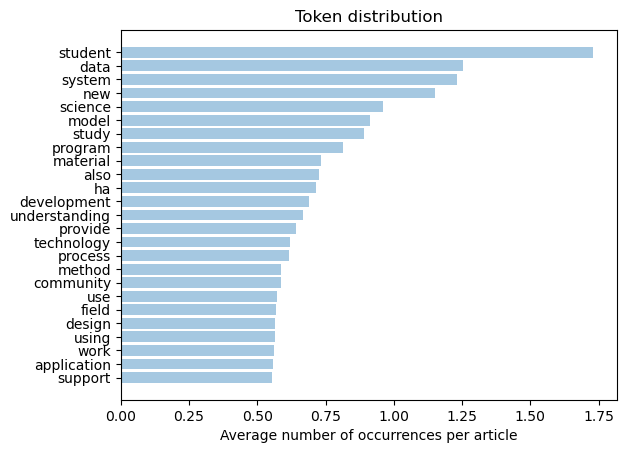

In [26]:
# SORTED TOKEN FREQUENCIES (II):
plt.rcdefaults()

# Example data
n_art = len(NSF_data)
n_bins = 25
hot_tokens = [D[i] for i in ids_sorted[n_bins-1::-1]]
y_pos = np.arange(len(hot_tokens))
z = tf_sorted[n_bins-1::-1]/n_art

plt.figure()
plt.barh(y_pos, z, align='center', alpha=0.4)
plt.yticks(y_pos, hot_tokens)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

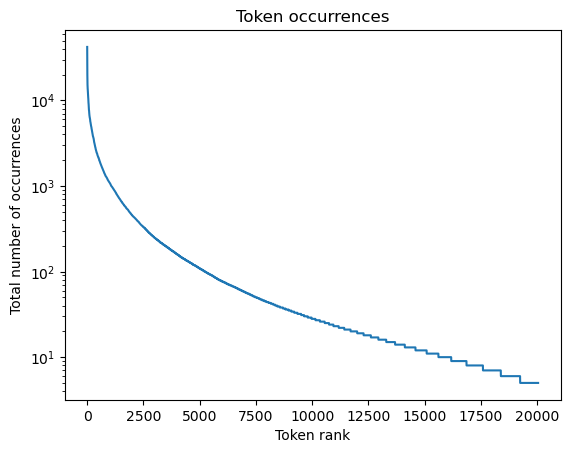

In [27]:
# SORTED TOKEN FREQUENCIES:

# Example data
plt.figure()
plt.semilogy(tf_sorted)
plt.ylabel('Total number of occurrences')
plt.xlabel('Token rank')
plt.title('Token occurrences')
plt.show()

**Exercise 10**: There are usually many tokens that appear with very low frequency in the corpus. Count the number of tokens appearing only once, and what is the proportion of them in the token list.

In [28]:
# cold_tokens = <FILL IN>
cold_tokens = [D[i] for i in ids_sorted if tf_sorted[i]==1]

print("There are {0} cold tokens, which represent {1}% of the total number of tokens in the dictionary".format(
    len(cold_tokens), float(len(cold_tokens))/n_tokens*100))

There are 0 cold tokens, which represent 0.0% of the total number of tokens in the dictionary


**Exercise 11**: Represent graphically those 20 tokens that appear in the highest number of articles. Note that you can use the code above (headed by `# SORTED TOKEN FREQUENCIES`) with a very minor modification.

In [ ]:
# <SOL>
# SORTED TOKEN FREQUENCIES (I):
# Count the number of occurrences of each token.
token_count2 = np.zeros(n_tokens)
for x in corpus_bow_flat:
    token_count2[x[0]] += (x[1]>0)

# Sort by decreasing number of occurences
ids_sorted2 = np.argsort(- token_count2)
tf_sorted2 = token_count2[ids_sorted2]

# SORTED TOKEN FREQUENCIES (II):
# Example data
n_bins = 25
hot_tokens2 = [D[i] for i in ids_sorted2[n_bins-1::-1]]
y_pos2 = np.arange(len(hot_tokens2))
z2 = tf_sorted2[n_bins-1::-1]

plt.barh(y_pos2, z2, align='center', alpha=0.4)
plt.yticks(y_pos2, hot_tokens2)
plt.xlabel('Number of articles')
plt.title('Token distribution')
plt.show()
# </SOL>

**Exercise 12**:  Count the number of tokens appearing only in a single article.


**Exercise (bigrams)**: `nltk` provides an utility to compute n-grams from a list of tokens, in `nltk.util.ngrams`. Join all tokens in `corpus_clean` in a single list and compute the bigrams. Plot the 20 most frequent bigrams in the corpus.

### 2.5. Dictionary properties

As a final comment, note that gensim dictionaries contain a method `dfs` to compute the word counts automatically. In the code below we build a list `all_counts` that contains tuples (terms, document_counts). 

In [ ]:
all_counts = [(D[el], D.dfs[el]) for el in D.dfs]
all_counts = sorted(all_counts, key=lambda x: x[1])